# Implementation of **SVM**
This notebook demonstrates the implementation of the ***SVM*** for Parkinson’s Disease detection using three feature processing methods:  
1. All Features (`Toutes caractéristiques`).  
2. Feature Selection (`La Sélection des caractéristiques`): ***Wrapper***, ***Embedding***, and ***ANOVA***.  
3. Dimensionality Reduction (`Réduction des données`) using ***PCA***.  

Each method is applied in two ways:  
- Using standard libraries.  
- Using custom implementations developed from scratch.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score 


from sklearn.svm import SVC
from Models.svm import SVM


## 1. Data Preprocessing  
- **Dataset**: Parkinson's Disease Classification (UCI Machine Learning Repository).  
- **Steps**:  
  1. Load and explore the dataset.  
  2. Handle missing values.  
  3. Normalize features using MinMaxScaler.  
  4. Balance classes using SMOTE.  
- Code snippets for preprocessing are shared below.


In [2]:

# Load the data
data = pd.read_csv("pd_speech_features.csv", header=1)


# Preprocess numeric columns
def safe_convert_numeric(df):
    numeric_columns = df.select_dtypes(include=['object']).columns
    for col in numeric_columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except Exception as e:
            print(f"Error converting column {col}: {e}")
    return df

data = safe_convert_numeric(data)

# Scale the features
scaler = StandardScaler()

# Identify numeric columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns[1:-1]
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Identify binary/categorical columns and other features
binary_features = ['gender']  # Adjust if needed
other_features = [col for col in data.columns if col not in binary_features + ['id', 'class']]

# Aggregate features with mean and std
aggregated_data = data.groupby('id')[other_features].agg(['mean', 'std']).reset_index()

# Flatten multi-level column names
aggregated_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in aggregated_data.columns]

# Add binary features back as-is
for feature in binary_features:
    aggregated_data[feature] = data.groupby('id')[feature].first().values.astype(data[feature].dtype)

# Add the target variable
aggregated_data['class'] = data.groupby('id')['class'].first().values

# Separate features and target
X = aggregated_data.drop(['class', 'id_'], axis=1)
y = aggregated_data['class']


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## 2.1 Method 1: Using All Features  
This section applies the ***SVM*** on the dataset using all features without any feature selection.  

### Implementation Approaches:  
1. **Using Standard Libraries** (e.g., scikit-learn, CatBoost).  
2. **Custom Implementation** of **SVM**.  

### Evaluation Metrics:  
- Accuracy, Precision, Recall, F1-Score, ROC-AUC.



Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.23      0.33        13
           1       0.78      0.95      0.86        38

    accuracy                           0.76        51
   macro avg       0.69      0.59      0.60        51
weighted avg       0.74      0.76      0.72        51


ROC AUC Score: 0.7773279352226721


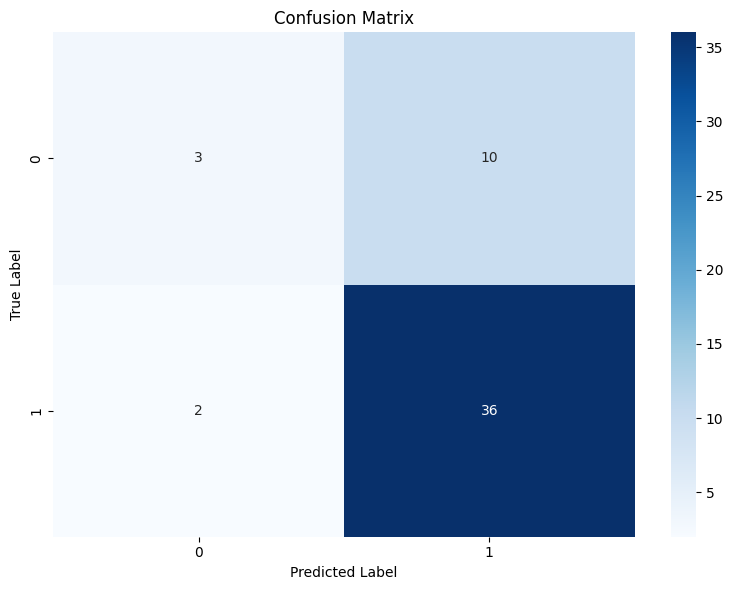

In [3]:

# Initialize and train the Support Vector Classifier (SVC)
svc_classifier = SVC(
    random_state=42, 
    probability=True  # Enables probability estimates for ROC AUC score
)
svc_classifier.fit(X_train, y_train)

# Predictions
y_pred = svc_classifier.predict(X_test)

# Evaluation Metrics
print("\nClassification Report:")
AllFeatures_SVC_report = classification_report(y_test, y_pred)
AllFeatures_SVC_acuracy = accuracy_score(y_test, y_pred)
print(AllFeatures_SVC_report)

# ROC AUC Score
if len(set(y_test)) == 2:  # Check if binary classification for ROC AUC
    y_prob = svc_classifier.predict_proba(X_test)[:, 1]  # Use probabilities for ROC AUC calculation
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"\nROC AUC Score: {roc_auc}")
else:
    print("\nROC AUC Score: Not applicable for multi-class classification")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.54      0.54        13
           1       0.84      0.84      0.84        38

    accuracy                           0.76        51
   macro avg       0.69      0.69      0.69        51
weighted avg       0.76      0.76      0.76        51


ROC AUC Score: 0.7773279352226721


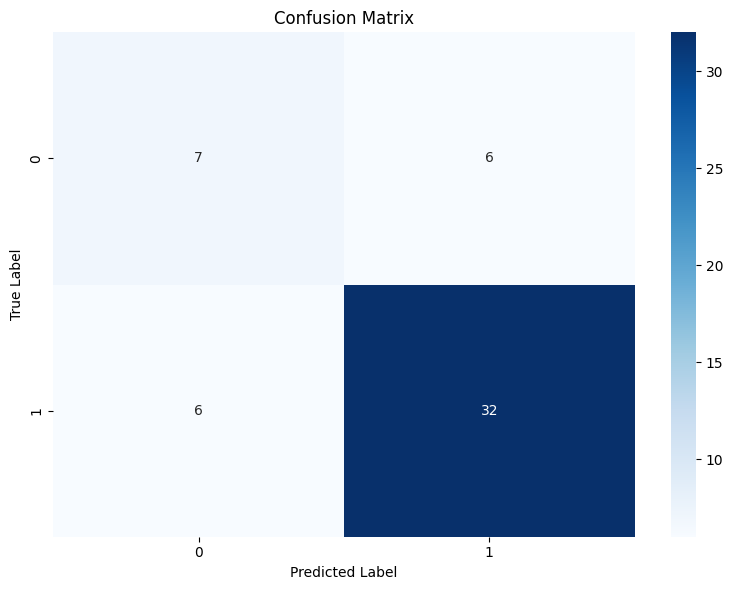

In [4]:
# train using the custom SVM model 
svm = SVM(
    learning_rate=0.01,
    n_iters=1000,
)

# train the model
svm.fit(X_train, y_train)

# predict the test set
y_pred = svm.predict(X_test)

# Evaluation Metrics
print("\nClassification Report:")
AllFeatures_SVM_report = classification_report(y_test, y_pred)
AllFeatures_SVM_acuracy = accuracy_score(y_test, y_pred)
print(AllFeatures_SVM_report)

# ROC AUC Score
if len(set(y_test)) == 2:  # Check if binary classification for ROC AUC
    y_prob = svm.predict_proba(X_test)  # Use probabilities for ROC AUC calculation
    print(f"\nROC AUC Score: {roc_auc}")
    
else:
    print("\nROC AUC Score: Not applicable for multi-class classification")
    
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


## 2.2 Method 2: Feature Selection  
Features are selected using three techniques: Wrapper, Embedding, and ANOVA. The union of selected features is used for model training.  

### Sub-methods:  
1. **Wrapper Method**: Backward elimination.  
2. **Embedding Method**: LassoCV.  
3. **ANOVA**: Statistical test for feature importance.  

### Evaluation Metrics:  
- Accuracy, Precision, Recall, F1-Score, ROC-AUC.


In [5]:
from SelectionType.EFSA.main import FeatureSelector

# Initialize the Feature Selector
selector = FeatureSelector(X_train, y_train)

selected_features = selector.comprehensive_feature_selection(k_features=70) # Perform feature selection based on anova embedding and wrapper methods


print(f"\nSelected Features: {selected_features}")


Selected Features: ['tqwt_entropy_log_dec_36_std', 'det_LT_entropy_log_4_coef_std', 'tqwt_medianValue_dec_22_std', 'tqwt_skewnessValue_dec_17_std', 'tqwt_entropy_shannon_dec_11_mean', 'tqwt_medianValue_dec_12_std', 'det_LT_entropy_log_8_coef_mean', 'tqwt_entropy_log_dec_12_mean', 'tqwt_stdValue_dec_12_mean', 'tqwt_kurtosisValue_dec_34_mean', 'mean_2nd_delta_mean', 'mean_MFCC_6th_coef_mean', 'tqwt_skewnessValue_dec_30_std', 'tqwt_kurtosisValue_dec_36_mean', 'tqwt_maxValue_dec_11_mean', 'std_delta_delta_log_energy_mean', 'mean_9th_delta_delta_std', 'tqwt_skewnessValue_dec_35_mean', 'det_LT_entropy_shannon_8_coef_mean', 'det_LT_entropy_log_2_coef_mean', 'tqwt_minValue_dec_11_mean', 'IMF_SNR_entropy_mean', 'det_LT_entropy_log_1_coef_mean', 'mean_10th_delta_std', 'tqwt_minValue_dec_10_mean', 'tqwt_kurtosisValue_dec_27_mean', 'std_7th_delta_delta_mean', 'det_LT_entropy_log_6_coef_std', 'std_10th_delta_delta_std', 'tqwt_medianValue_dec_1_std', 'det_LT_entropy_log_6_coef_mean', 'det_LT_entrop


Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.54      0.54        13
           1       0.84      0.84      0.84        38

    accuracy                           0.76        51
   macro avg       0.69      0.69      0.69        51
weighted avg       0.76      0.76      0.76        51


ROC AUC Score: 0.7408906882591093


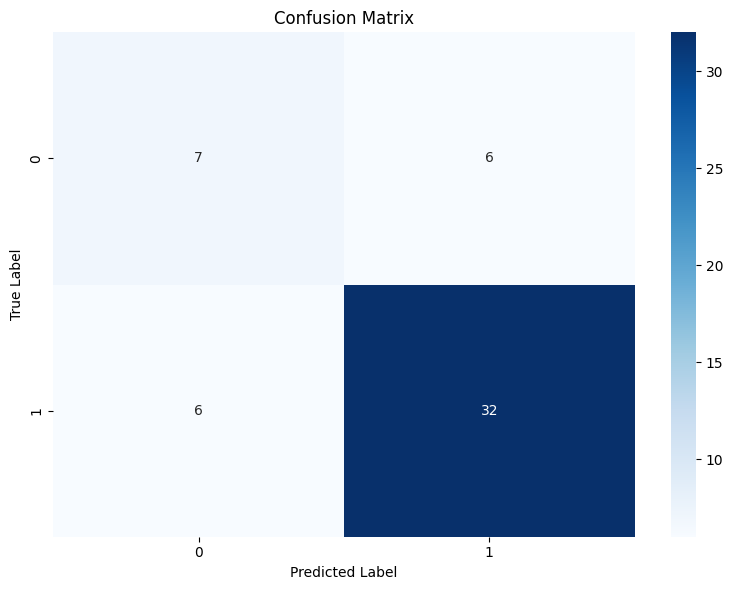

In [6]:
# train the SVC model using the selected features

svc_classifier = SVC(
    random_state=42, 
    probability=True  # Enables probability estimates for ROC AUC score
)

svc_classifier.fit(X_train[selected_features], y_train)

# Predictions
y_pred = svc_classifier.predict(X_test[selected_features])

# Evaluation Metrics
print("\nClassification Report:")
SelectedFeatures_SVC_report = classification_report(y_test, y_pred)
SelectedFeatures_SVC_acuracy = accuracy_score(y_test, y_pred)
print(SelectedFeatures_SVC_report)


# ROC AUC Score
if len(set(y_test)) == 2:  # Check if binary classification for ROC AUC
    y_prob = svc_classifier.predict_proba(X_test[selected_features])[:, 1]  # Use probabilities for ROC AUC calculation
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"\nROC AUC Score: {roc_auc}")
    
else:
    print("\nROC AUC Score: Not applicable for multi-class classification")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [7]:
#trains the SVM model using the selected features
svm = SVM(
    learning_rate=0.01,
    n_iters=1000,
)

# train the model
svm.fit(X_train[selected_features], y_train)

# predict the test set
y_pred_svm_selected = svm.predict(X_test[selected_features])

# Evaluation Metrics
print("\nClassification Report:")
SelectedFeatures_SVM_report = classification_report(y_test, y_pred_svm_selected)
SelectedFeatures_SVM_acuracy = accuracy_score(y_test, y_pred_svm_selected)
print(SelectedFeatures_SVM_report)



Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.54      0.47        13
           1       0.82      0.74      0.78        38

    accuracy                           0.69        51
   macro avg       0.62      0.64      0.62        51
weighted avg       0.72      0.69      0.70        51



## 2.3 Method 3: Dimensionality Reduction  
Principal Component Analysis (PCA) is used to reduce the dataset's dimensionality before applying the **SVM**.   

### Evaluation Metrics:  
- Accuracy, Precision, Recall, F1-Score, ROC-AUC.


In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from SelectionType.acp import PCAFromScratch
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Splitting the data into train and test sets to prevent overfitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

pca = PCAFromScratch(n_components=80)  # Adjust number of components as needed


# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to the scaled dataset
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Ensure data is float type
X_train_pca = X_train_pca.astype(float)
X_test_pca = X_test_pca.astype(float)

# Initialize Support Vector Classifier with kernel and regularization
svc_pca = SVC(
    kernel='rbf',  # Radial Basis Function kernel
    random_state=42,
    probability=True  # Enable probability estimates
)

# Train the SVC on PCA-transformed data
svc_pca.fit(X_train_pca, y_train)

# Predict on the test set
y_pred_svc_pca = svc_pca.predict(X_test_pca)

# Evaluation Metrics
pca_svc_accuracy = accuracy_score(y_test, y_pred_svc_pca)
pca_svc_report = classification_report(y_test, y_pred_svc_pca)

print("Support Vector Classifier with PCA:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc_pca)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_svc_pca)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_svc_pca)}")

Support Vector Classifier with PCA:
Accuracy: 0.7843137254901961
Confusion Matrix:
[[ 4  9]
 [ 2 36]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.31      0.42        13
           1       0.80      0.95      0.87        38

    accuracy                           0.78        51
   macro avg       0.73      0.63      0.64        51
weighted avg       0.77      0.78      0.75        51



C:\Users\bouma\AppData\Local\Temp\ipykernel_36664\638924371.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train_pca = X_train_pca.astype(float)
C:\Users\bouma\AppData\Local\Temp\ipykernel_36664\638924371.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  X_test_pca = X_test_pca.astype(float)


In [12]:
# tran using the svm model
svm = SVM(
    learning_rate=0.01,
    n_iters=1000,
)

# train the model
svm.fit(X_train_pca, y_train)

# predict the test set
y_pred_svm_pca = svm.predict(X_test_pca)

# Evaluation Metrics
print("\nClassification Report:")
pca_svm_report = classification_report(y_test, y_pred_svm_pca)
pca_svm_accuracy = accuracy_score(y_test, y_pred_svm_pca)
print(pca_svm_report)





Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.62      0.52        13
           1       0.85      0.74      0.79        38

    accuracy                           0.71        51
   macro avg       0.65      0.68      0.65        51
weighted avg       0.75      0.71      0.72        51



## 3. Comparative Analysis  
- **Objective**: Compare the performance of the **SVM** across:  
  1. All Features.  
  2. Feature Selection.  
  3. PCA.  
- **Comparison Metrics**:  
  - Performance (Accuracy, Precision, Recall, F1-Score, ROC-AUC).  
  - Computational efficiency (Training and Testing Time).  
- Present results as tables and visualizations (e.g., bar plots, ROC curves).  


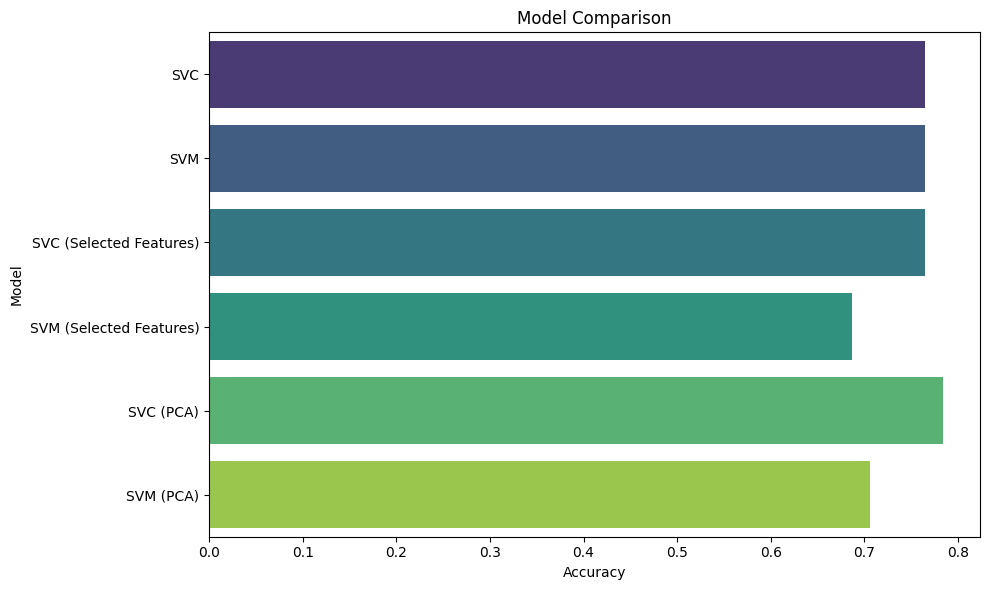

In [18]:
# performace comparison between the two models using all features and selected features and PCA

# Create a DataFrame for the results
results = pd.DataFrame({
    'Model': ['SVC', 'SVM', 'SVC (Selected Features)', 'SVM (Selected Features)', 'SVC (PCA)', 'SVM (PCA)'],
    'Accuracy': [AllFeatures_SVC_acuracy, AllFeatures_SVM_acuracy, SelectedFeatures_SVC_acuracy, SelectedFeatures_SVM_acuracy, pca_svc_accuracy, pca_svm_accuracy],
    'Classification Report': [AllFeatures_SVC_report, AllFeatures_SVM_report, SelectedFeatures_SVC_report, SelectedFeatures_SVM_report, pca_svc_report, pca_svm_report]
})


# plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results, palette='viridis', hue='Model')
plt.title('Model Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.tight_layout()
plt.show()